**Marfa Zakirova, B06-906a**

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch, torch.nn as nn
import numpy as np
from random import sample
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
import torchsummary
from matplotlib import pyplot as plt
from tqdm import tqdm

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

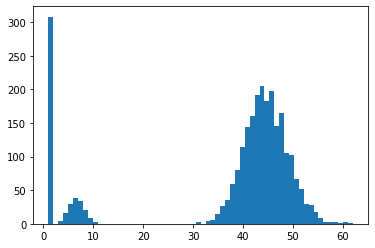

In [37]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    import os

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]

start_token = "<"
text = [start_token + line[:-2] for line in text] # to remove '\n'

MAX_LENGTH = max(map(len, text))
assert len(text) == 2616
plt.hist(list(map(len, text)),bins=MAX_LENGTH)
None

**Rows that are shorter than 30 symbols do not contain the semantic load of the sonnet, most likely they are needed for the organization of the text. We will remove them, since the model must first solve a simpler task: generate sonnet strings**

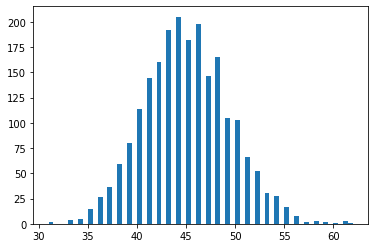

In [39]:
text = [text[i].lower() for i in range(len(text)) if len(text[i]) >= 30]
plt.hist(list(map(len, text)),bins=MAX_LENGTH)
None

In [40]:
print(text)

['<  from fairest creatures we desire increase', "<  that thereby beauty's rose might never die", '<  but as the riper should by time decease', '<  his tender heir might bear his memory', '<  but thou, contracted to thine own bright eyes', "<  feed'st thy light's flame with self-substantial fuel", '<  making a famine where abundance lies', '<  thy self thy foe, to thy sweet self too cruel', "<  thou that art now the world's fresh ornament", '<  and only herald to the gaudy spring', '<  within thine own bud buriest thy content', "<  and tender churl mak'st waste in niggarding", '<    pity the world, or else this glutton be', "<    to eat the world's due, by the grave and thee", '<  when forty winters shall besiege thy brow', "<  and dig deep trenches in thy beauty's field", "<  thy youth's proud livery so gazed on now", "<  will be a tatter'd weed of small worth held", '<  then being asked, where all thy beauty lies', '<  where all the treasure of thy lusty days', '<  to say, within thi

**I decided not to join the text, because I thought that the model should learn how to generate sonnet lines, looking at the lines, and not intermittent pieces of text. Moreover, the task turns out to be as close as possible to the task of generating names. I also added sos, eos, and took into account the fact that we do not penalize the model for generating short strings**

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [41]:
# Join all the strings into one and lowercase it
# Put result into variable text.
 
# done while previous preprocessing

MAX_LENGTH = max(map(len, text))

assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')


OK!


### Data loading: "Евгений Онегин"


In [42]:
# !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
# with open('onegin.txt', 'r') as iofile:
#     text = iofile.readlines()
    
# text = [x.replace('\t\t', '') for x in text]


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [43]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
# text_join = ''.join(text).lower()
# assert not any([x in set(text_join) for x in string.ascii_uppercase]), 'Uppercase letters are present'

Put all the characters, that you've seen in the text, into variable `tokens`.

In [44]:
tokens = sorted(set(''.join(text)))

tokens.append('_')
tokens.append('>')
num_tokens = len(tokens)

print(f'# unique tokens: {num_tokens}', '\n')
print(f'example: {tokens[8:15]}')

# unique tokens: 40 

example: [':', ';', '<', '?', 'a', 'b', 'c']


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [45]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: val for i, val in enumerate(tokens)}


# dict <char>:<index>
# Your great code here
token_to_idx = {val:i for i,val in enumerate(tokens)}

assert len(idx_to_token) == len(token_to_idx)

In [46]:
# def char_to_tensor(line, token_idx = token_to_idx):
#   return torch.LongTensor([token_idx[char] for char in line])

# encoded_text_join =  char_to_tensor(text_join, token_to_idx)
# encoded_text_join[:5]


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [47]:
def to_matrix(text:list, pad=token_to_idx['_'], dtype='int32', batch_first=True):
    """
    Casts a list of text into rnn-digestable matrix
    """
    
    max_len = MAX_LENGTH + 1
    n_rows = len(text)

    text_ix = np.zeros([n_rows, max_len], dtype) + pad
    text_ix[:, 0] = token_to_idx['<'] # <SOS>

    for i in range(n_rows):
        line_ix = [token_to_idx[char] for char in text[i]]
        text_ix[i, 1:len(line_ix)] = line_ix[1:]
        text_ix[i, len(line_ix)] = token_to_idx['>'] # <EOS>

        
    if not batch_first: # convert [batch, time] into [time, batch]
        text_ix = np.transpose(text_ix)

    return text_ix

In [48]:
# from seminar
class Vanilla_char_RNN(nn.Module):
   
    def __init__(
        self,
        num_tokens: int=len(tokens),
        embedding_size: int=64,
        rnn_num_units: int=128
    ):
        super(Vanilla_char_RNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        out, h_next = self.rnn(x_emb, h_prev)
        logits = self.linear(out)
        return h_next, logits
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.rnn_num_units, requires_grad=True)

In [49]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    
    logits = []

    for i, x_t in enumerate(batch_ix.transpose(0,1)):
      if len(hid_state) != 1:   # initial state, need for one-to-one comparison in RNN
         hid_state = hid_state[i, :][None,:]

      hid_state, logits_next = char_rnn(x_t, hid_state)
      logits.append(logits_next)
        
    return torch.stack(logits, dim=1)

In [51]:
def train(model: nn.Module,model_loop, n_epochs: int=16, optim=None, loss_fn = None, batch_size: int=150):
    losses = []
    state = model.initial_state(batch_size)

    for epoch in tqdm(range(n_epochs)):
        optim.zero_grad()

        ind = np.random.choice(len(text), batch_size, replace = False)
        batch_ix = to_matrix([text[i] for i in ind])
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

        logits_seq = model_loop(model, batch_ix)  
            
        predictions_logits = logits_seq[:, :-1]
        actual_next_tokens = batch_ix[:, 1:]


        loss = loss_func(
        predictions_logits.reshape((-1, num_tokens)),
        actual_next_tokens.reshape(-1)
        )
        losses.append(loss.item())
        loss.backward()
        optim.step()
        
    return losses

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [52]:
# Your plot code here

def plot_train_process(train_loss):
  plt.figure(figsize = (10,6))
  plt.title('Loss')
  plt.xlabel('# epochs')
  plt.ylabel('loss value')
  plt.plot(train_loss,label='train')
  plt.legend()
  plt.grid(which = 'major')
  plt.show()

100%|██████████| 500/500 [05:03<00:00,  1.65it/s]


 Min loss value: 2.23831


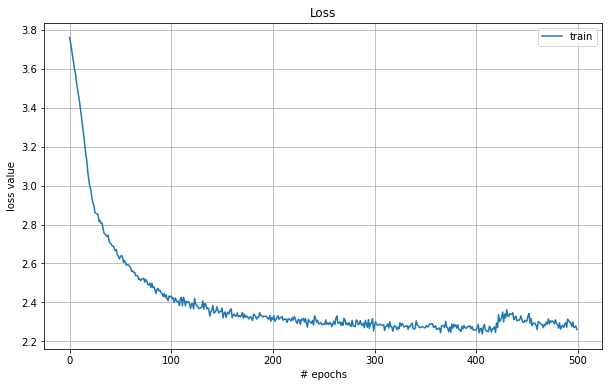

In [53]:
model = Vanilla_char_RNN(rnn_num_units = MAX_LENGTH)
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])

vanilla_losses = train(model,rnn_loop, n_epochs = 500, optim = optimizer, loss_fn = loss_func)

print('\n', f'Min loss value: %.5f' % min(vanilla_losses))
plot_train_process(vanilla_losses)

In [54]:
def generate_sample(char_rnn, seed_phrase='<', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    char_rnn.eval()

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logits_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        if next_ix == token_to_idx['>']:
          break
    res = ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])
    if res[0] == '<':
      res = res[1:]
    if res[-1] == '>':
      res = res[:-1]
    return res

In [66]:
model.eval()
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("Temperature: %.1f" %t)
    for _ in range(5):
      print(generate_sample(model, seed_phrase="sir ", temperature=t))
    print('\n')
  

Temperature: 0.1
sir the the the the the the the the the the the the the the th
sir the the the the the the the the the the the the the the th
sir the the the the the the the the the the the the t the the 
sir the the the the the the t the the the the the the the the 
sir the the the the the the the the the the the the the the th


Temperature: 0.2
sir the the the the than the the the me my the the the the the
sir the the the the the the the the the the the the t the t th
sir the the the the the t the the the t the the s the t the t 
sir thanon the the t the t the s the the the the the t the t t
sir the the the s the the the my the the the the the the the i


Temperature: 0.5
sir inon se alll t w m t s y he me i alond whe thing t thor an
sir t y buth mat the thang f thes ban athen ing my the wh ther
sir t t li n he llot fe t  owhere mean t s thand in the pe s t
sir win t de the pure den hithe t whend t whou d m thangen t w
sir d chi s ace my ouro thant tho d  an be ten thind t wouther


**The lower the temperature, the more conservative the words are given by the model and more similar to the normal text. The fact that he is delusional is most likely due to embedding**

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [56]:
class LSTM_char_RNN(nn.Module):
   
    def __init__(
        self,
        num_tokens: int=len(tokens),
        embedding_size: int=64,
        rnn_num_units: int=128
    ):
        super(LSTM_char_RNN, self).__init__()
        self.rnn_num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.linear = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, states = None):
      """
      states = h_prev + long_term_memory_prev
      """
      x_emb = self.embedding(x)
      if states is None:
          states = self.initial_state(1)
      out, states = self.lstm(x_emb, states)
      
      logits = self.linear(out)
      return states, logits
    
    def initial_state(self, batch_size):
        return [torch.zeros(1, self.rnn_num_units, requires_grad=True),
                torch.zeros(1, self.rnn_num_units, requires_grad=True)]

In [57]:
def lstm_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    states = h_prev + long_term_memory_prev
    """
    batch_size, max_length = batch_ix.size()
    states = char_rnn.initial_state(1)
    
    logits = []

    for x_t in batch_ix.transpose(0,1):
      hidden_state, long_state = states

      states = [hidden_state, long_state]

      states, logits_next = char_rnn(x_t, states)
      logits.append(logits_next)
        
    return torch.stack(logits, dim=1)

Plot the loss function of the number of epochs. Does the final loss become better?

100%|██████████| 500/500 [13:26<00:00,  1.61s/it]



 Min loss value: 2.23393


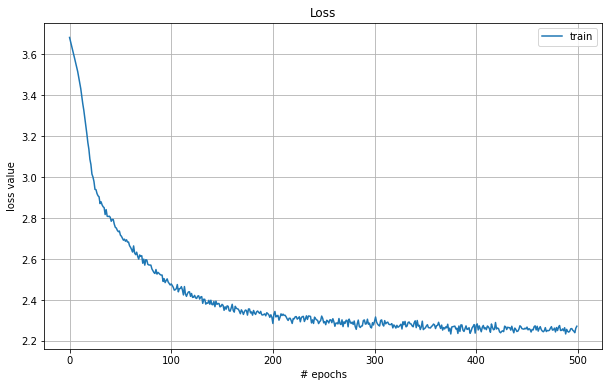

In [58]:
lstm_model = LSTM_char_RNN(rnn_num_units = MAX_LENGTH)
optimizer = torch.optim.Adam(lstm_model.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])

lstm_losses = train(lstm_model,lstm_loop, n_epochs = 500, optim = optimizer, loss_fn = loss_func)

print('\n',f'Min loss value: %.5f' % min(lstm_losses))
plot_train_process(lstm_losses)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [64]:
# Text generation with different temperature values here

lstm_model.eval()
for t in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("Temperature: %.1f" %t)
    for _ in range(5):
      print(generate_sample(lstm_model, seed_phrase="sir ", temperature=t))
    print('\n')

Temperature: 0.1
sir the the the the the the the the the the the the the the th
sir the the the the t the the the the the the the the the the 
sir the the the the the the the the the the the the the the th
sir the the the the the the the the the the the the the the th
sir the the the the the the the the the the the the the the th


Temperature: 0.2
sir the the the the the t than the the the the the be the the 
sir the the than the s the the the the the the than the the th
sir the the t the t the the the the the the the t the whathe t
sir and the the the thanouthe there the the than the thathe th
sir the the the the the the the th t the the the t the the the


Temperature: 0.5
sir the s thatin s whan the d t  t me sower by sowowind st th 
sir he torthan th te t chan mere n t the s ananeathese whase t
sir be thy wan is the thorthis be or tho my wache an thor t t 
sir wholenoun  be fous the n s be m  towhomy winore s chathe a
sir and shend my in the be the whe tho nouth ore the at the th


**At low temperatures, the behaviors of LSTM and Vanilla_RNN are similar - both generate conservative words, and the results are almost identical to each other. When the temperature rises, LSTM shows results more similar to ordinary English than Vanilla_RNN, as expected in theory**

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [60]:
# Saving and loading code here
torch.save(lstm_model.state_dict(), 'lstm_model_sonnet.pth')


In [61]:
copy_lstm_model = LSTM_char_RNN(rnn_num_units = MAX_LENGTH)
copy_lstm_model.load_state_dict(torch.load('lstm_model_sonnet.pth'))
copy_lstm_model.eval()

LSTM_char_RNN(
  (embedding): Embedding(40, 64)
  (lstm): LSTM(64, 62, batch_first=True)
  (linear): Linear(in_features=62, out_features=40, bias=True)
)

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)